## Group Project: EPA FE Analysis and Prediction

### Context: 


### Objective : 

* To identify the different factors that affect fuel economy in surveyed vehicles
* To make a model to predict if an employee will attrite or not


### Dataset :
The data contains (replace - demographic details), (replace - work-related metrics) and (replace - attrition flag).

* **Metric** - Definition


### Import the necessary libraries

In [35]:
# Note: go through later and removed unused dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

#for tuning the model
from sklearn.model_selection import GridSearchCV

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Read the dataset
Additionally, perform some cleaning and some column combination/drops as agreed upon during prior inspection of the data pool.

In [36]:
#reading the dataset

# use the commented out df definition to import only the columns specified in the above list
df = pd.read_csv('table_export_unclean.csv')

# drop columns decided to be unwanted for our analysis
drops = ['Vehicle Type','Production (000)','Production Share','Real-World MPG','Real-World MPG_City','Real-World MPG_Hwy','Real-World CO2 (g/mi)',
        'Real-World CO2_City (g/mi)','Real-World CO2_Hwy (g/mi)','HP/Weight (lbs)','Ton-MPG (Real-World)','Transmission - Other','Fuel Delivery - Carbureted',
        'Fuel Delivery - Throttle Body Injection','Powertrain - Fuel Cell Vehicle (FCV)','Powertrain - Other (incl. CNG)','HP/Engine Displacement',
        '4 or Fewer Gears','5 Gears','6 Gears','7 Gears','8 Gears','9 or More Gears']

df = df.drop(drops, axis = 1)

# erroneous entries requiring replacement
df = df.replace('-', np.NaN)
df = df.replace('Prelim. 2021', '2021')

# attempt to convert columns from object to numeric type wherever possible - df.infer_objects() wasn't cutting it
cols = df.columns
for col in cols:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# drop all data before MY 2005, drop MY 2021
df = df.loc[(df["Model Year"] > 2005) & (df["Model Year"] < 2021)]

# combine two transmission columns, two drivetrain columns, and two powertrain columns, dropping the originals
df['Transmission - Automatic + Lockup'] = df['Transmission - Automatic'] + df['Transmission - Lockup']
df['Powertrain - PHEV + Gas Hybrid'] = df['Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)'] + df['Powertrain - Gasoline Hybrid']
df['Drivetrain - Front + Rear'] = df['Drivetrain - Rear'] + df['Drivetrain - Front']
df = df.drop(columns = ['Transmission - Automatic','Transmission - Lockup','Powertrain - Plug-in Hybrid Electric Vehicle (PHEV)',
                        'Powertrain - Gasoline Hybrid','Drivetrain - Rear','Drivetrain - Front'])

df.head()

,Manufacturer,Model Year,Regulatory Class,2-Cycle MPG,Weight (lbs),Footprint (sq. ft.),Engine Displacement,Horsepower (HP),Acceleration (0-60 time in seconds),Drivetrain - 4WD,...,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV + Gas Hybrid,Drivetrain - Front + Rear
31,All,2006,All,25.16908,4066.533,NaN,204.1170,213.1841,8.9232,0.258,...,0.021,NaN,0.036,0.717,0.554,4.6,0.014,0.906,NaN,0.742
32,All,2007,All,25.78828,4093.315,NaN,202.5384,216.9897,8.9147,0.261,...,0.025,NaN,0.073,0.717,0.573,4.8,0.051,0.871,NaN,0.739
33,All,2008,All,26.26150,4085.003,48.85985,198.9670,218.5559,8.9327,0.273,...,0.030,NaN,0.067,0.764,0.582,4.8,0.055,0.870,NaN,0.727
34,All,2009,All,28.19485,3914.193,47.93705,182.9433,207.7209,8.8040,0.235,...,0.033,NaN,0.073,0.838,0.715,5.0,0.073,0.858,NaN,0.765
35,All,2010,All,28.44213,4001.323,48.54913,187.5701,213.6361,8.7827,0.267,...,0.033,NaN,0.064,0.855,0.838,5.2,0.072,0.853,NaN,0.733


### Dataset Info

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 31 to 5155
Data columns (total 28 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Manufacturer                                     1650 non-null   object 
 1   Model Year                                       1650 non-null   int64  
 2   Regulatory Class                                 1650 non-null   object 
 3   2-Cycle MPG                                      1496 non-null   float64
 4   Weight (lbs)                                     1496 non-null   float64
 5   Footprint (sq. ft.)                              1302 non-null   float64
 6   Engine Displacement                              1458 non-null   float64
 7   Horsepower (HP)                                  1496 non-null   float64
 8   Acceleration (0-60 time in seconds)              1496 non-null   float64
 9   Drivetrain - 4WD             

## Exploratory Data Analysis and Data Preprocessing

In [39]:
# What should we do about manufacturer = "All"?
df.Manufacturer.unique()

array(['All', 'GM', 'Honda', 'BMW', 'Ford', 'Hyundai', 'Stellantis',
       'Mazda', 'Toyota', 'VW', 'Nissan', 'Subaru', 'Tesla', 'Kia',
       'Mercedes'], dtype=object)

### Check summary statistics

In [40]:
df.describe()

,Model Year,2-Cycle MPG,Weight (lbs),Footprint (sq. ft.),Engine Displacement,Horsepower (HP),Acceleration (0-60 time in seconds),Drivetrain - 4WD,Transmission - Manual,Transmission - CVT (Hybrid),...,Turbocharged Engine,Stop/Start,Cylinder Deactivation,Multivalve Engine,Variable Valve Timing,Average Number of Gears,Transmission - CVT (Non-Hybrid),Transmission - Automatic + Lockup,Powertrain - PHEV + Gas Hybrid,Drivetrain - Front + Rear
count,1650.000000,1496.000000,1496.000000,1302.000000,1458.000000,1496.000000,1496.000000,1248.000000,999.000000,402.000000,...,941.000000,456.000000,482.000000,1435.000000,1420.000000,1486.000000,511.000000,326.000000,209.000000,764.000000
mean,2013.000000,32.256521,4141.157400,49.650575,181.548381,234.012566,8.370002,0.470441,0.050312,0.037276,...,0.272272,0.364079,0.237247,0.924510,0.885358,5.586541,0.344395,0.886988,0.059158,0.717200
std,4.321804,17.689531,618.119367,5.289381,45.425144,58.005498,1.033096,0.342045,0.061122,0.048949,...,0.316638,0.344723,0.264976,0.179864,0.229844,1.543500,0.344593,0.129525,0.054036,0.270061
min,2006.000000,15.410690,2997.372000,42.561640,94.121100,131.000000,3.295600,0.005000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.024000,0.001000,1.000000,0.001000,0.228000,0.000000,0.109000
25%,2009.000000,25.623330,3634.138250,45.990570,145.074300,191.050500,7.907200,0.124000,0.011000,0.005250,...,0.033000,0.046750,0.036000,0.972000,0.930750,4.900000,0.041500,0.838000,0.023000,0.511000
50%,2013.000000,29.113360,4014.592000,47.709235,171.296900,223.806550,8.492950,0.452500,0.031000,0.020000,...,0.114000,0.251000,0.128000,1.000000,0.998000,5.800000,0.178000,0.924000,0.045000,0.791500
75%,2017.000000,33.962852,4543.552750,51.965218,212.432025,267.617825,8.956300,0.768750,0.062000,0.043000,...,0.443000,0.690750,0.363500,1.000000,1.000000,6.200000,0.691000,0.979750,0.075000,0.957250
max,2020.000000,176.245670,6668.898000,68.433210,366.142200,566.456600,11.797900,1.000000,0.474000,0.266000,...,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,0.275000,1.000000


### Attempt correlation analysis

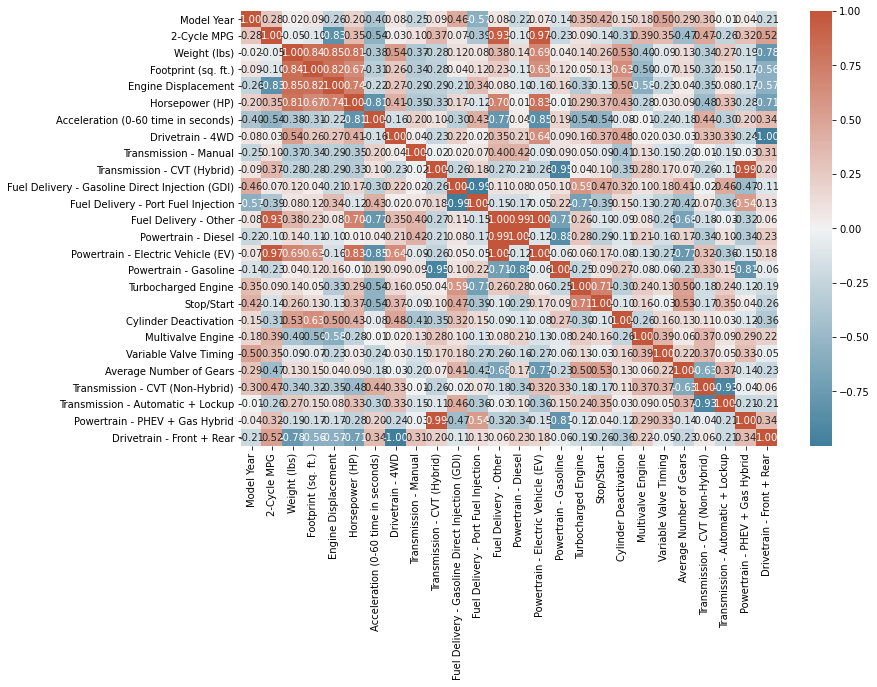

In [41]:
plt.figure(figsize=(12,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap )
plt.show()